## Automatic Learning of Summary Statistics for Approximate Bayesian Computation Using Deep Learning



Samuel Wiqvist, Ph.D. student, Lund University.

Work with: Pierre-Alexandre Mattei (ITU), Umberto Picchini (GU/Chalmers), and Jes Frellsen (ITU). 

In [1]:
# load packages and set up
using PyPlot
using Distributions
using Printf
using Random 
using KernelDensity

# data model
Random.seed!(12)
α = 2; β = 2
m = 4; n = 5; p = 0.7
y_obs = rand(Binomial(m,p),n) # generate data

# analytical posterior
posterior = Beta(α + sum(y_obs), β + m*n - sum(y_obs));

# plot function
function plot_abc_inference_results(abc_posterior_samples)
    
    kde_approx_posterior = kde(abc_posterior_samples)

    # plot results
    PyPlot.figure(figsize=(7,4))
    PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
    PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
    PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
    PyPlot.plot((p, p), (0, maximum(pdf.(posterior, 0:0.01:1))), "k")
    PyPlot.xlabel("p")
    PyPlot.ylabel("Density")
    PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "Ground truth"])

end 

┌ Info: Recompiling stale cache file /home/samuel/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/samuel/.julia/compiled/v1.0/KernelDensity/4QyGx.ji for KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1184


plot_abc_inference_results (generic function with 1 method)

#### What we will talk about today

* Introduction to ABC;


* How to leverage deep learning methods to learn the summary statistics for ABC; 
    * Present the main results from the paper:  *Partially Exchangeable Networks and Architectures for Learning Summary Statistics in Approximate Bayesian Computation* (accepted for ICML 2019);


* We will have a practical focus and run ABC for a simple model (the Beta-Binomial model).   

#### Approximate Bayesian Computation: Simulation based inference 

* ABC in a nut-shell: Simulations-based inference method where we generate parameter proposal $\theta^\star$ and accept $\theta^\star$ if the generated data $y^{\star}\sim p(y|\theta^\star)$ is *similar* to our observed data $y^{\text{obs}}$;

* ABC only requires that we can simulate data from a computer simulator of our model $p(y|\theta)$.

* Thus, ABC is very generic, and can be applied for models where the likelihood function is intractable.   

* *Curse-of-dimensionality*: Instead of comparing the data sets we compare a set of summary statistics $s =S(y)$. The main focus of our work is how to  *automatically* learn the summary statistics. (For example for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For i.i.d. data could be quantiles, mean and standard deviation etc.;)


#### Approximate Bayesian Computation: Rejection sampling method 

* Generate $\tilde{N}$ independent proposals $\theta^i\sim p(\theta)$,  and corresponding data sets  $y^i\sim p(y|\theta^i)$ from the computer simulator $p(y|\theta)$;

* Compute the summary statistics $s^i = S(y^i)$ for each $i=1,\ldots,\tilde{N}$;

* Compute the distances $\Delta(s^{i}, s^{\text{obs}})$ for each $i=1,\ldots,\tilde{N}$. 

* Retain proposals $\theta^i$ corresponding to those $\Delta(s^{i}, s^{\text{obs}})$ such that  $\Delta(s^{i}, s^{\text{obs}}) \leq \epsilon$, for some  $\epsilon \geq 0$; 

* We sample from $p^{\epsilon}_{\text{ABC}}(\theta^{\star} | s^{\text{obs}})$. 

#### ABC rejection sampling for the Beta-Binomial model

Model: $$y \sim \text{Binomial}(m,p),$$ $$p \sim \text{Beta}(\alpha, \beta).$$ 


In [2]:
# Define the model and the prior distribution.

Random.seed!(12) # fix random numbers 

# model parameters
m = 4; n = 5; p_true = 0.7

# define the data generating function
data_generator(p) = rand(Binomial(m,p),n) 

# generate data
y_obs = data_generator(p_true)

# prior 
α = 2; β = 2
prior = Beta(α,β);


#### ABC rejection sampling for the Beta-Binomial model 

In [3]:
# define the summary statistics 
S_handpicked(y) = sum(y); # canonical statistic, i.e. the statistic is sufficient!

In [4]:
# ABC rejection sampling algorithm 
function abc_rs(;N_proposals::Int, ϵ::Real, S::Function)
    
    abc_posterior_samples = zeros(N_proposals) 
    nbr_accepted_proposals = 0 
    
    s_obs = S(y_obs) # compute summary statistics for obs. data 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the computer simulator 
        Δ =  abs(S(y_star)-s_obs) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accepted_proposals += 1 
            abc_posterior_samples[nbr_accepted_proposals] = p_star 
        end 
        
    end 
    
    return abc_posterior_samples[1:nbr_accepted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model

In [30]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0.1, S=S_handpicked);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 6.76 %

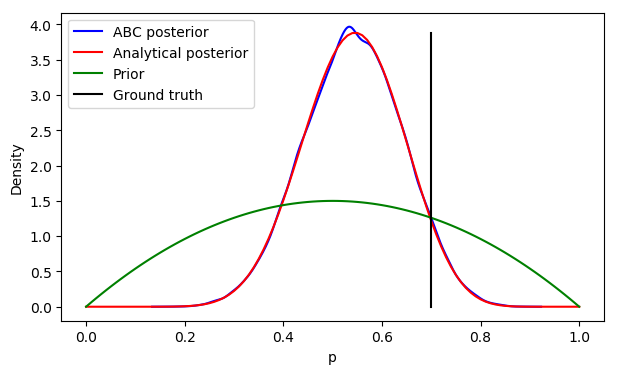

In [31]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### How to select/learn summary statistics

* The summary statistics *should* be low-dimensional and informative for the parameters (in the ideal case sufficient).

* The problem of selecting informative summary statistics is the main challenge when applying ABC in practice;

* Usually, summary statistics are ad-hoc and "handpicked" out of subject-domain expertise. For example for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For i.i.d. data could be quantiles, mean and standard deviation etc.;

* Several methods to learn/select summary statistics have been developed (see (Prangle, 2015) for a review on these methods);

#### Learning summary statistics using linear regression

* An important paper is Fearnhead & Prangle, 2012 where they use linear regression to learn summary statistics, they also show that the posterior mean is the *best* (in terms of loss for the posterior mean) summary statistic; 

* The semi-automatic ABC method (Fearnhead & Prangle, 2012):
    * We can sample a set of parameter-data pairs $(\theta^{i}, y^i)_{1 \leq i \leq N}$, by sampling $\theta^{i}$ from the prior $p(\theta)$, and then simulate corresponding data set $y^{i}$ from the simulator $p(y|\theta)$;    
    * Learn the posterior mean from the $N$ simulations,  using a linear regression model: $$\theta_j^i = E(\theta_j | y^i) + \xi_j^i = b_{0_j} + b_j h(y^i) + \xi_j^i.$$
    * After fitting the linear regression model $S_j(y^{\star}) = \tilde{b}_{0_j} + \tilde{b}_j h(y^{\star})$ is the j:th summary statistics for the proposed data set $y^{\star}$. 

#### Semi-automatic ABC for the Beta-Binomial model: Step 1: Generate data

In [7]:
# generate parameter-data pairs  
N = 1000
parameters = rand(prior, N)
data = zeros(N,5)
for i in 1:N; data[i,:] = data_generator(parameters[i]); end

#### Semi-automatic ABC for the Beta-Binomial model: Step 2: Fit linear regression model

In [8]:
# Fit linear regression model 
β = (data'*data)\data'*parameters; # ls estimation 

In [9]:
# Define the new function to compute the summary statistic 
S_semi_auto(y) = y'*β;

#### Semi-automatic ABC for the Beta-Binomial model: Step 2: Run ABC algorithm

In [26]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0.02, S=S_semi_auto);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 6.80 %

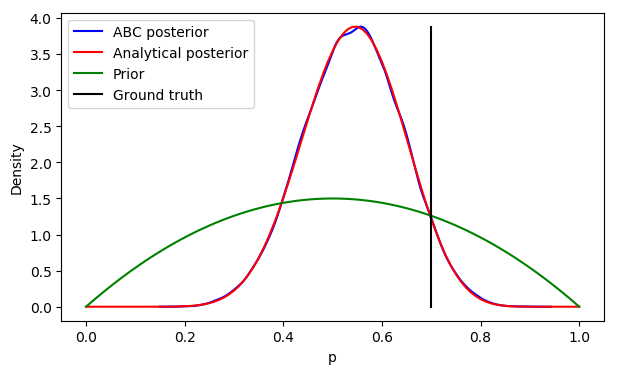

In [27]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### Replacing linear regression with multilayer perceptron (MLP) network


* In Jiang et al., 2017 they replace the linear regression model with a MLP network, thus they have following regression model: $$\theta^i = E(\theta|y^i) + \xi^i = f_{\beta}(y^i) + \xi^i.$$
    Where $f_{\beta}$ is the MLP parameterized by the weights $\beta$.


<img src="fig/dnn_structure.PNG" width="800" height="800" align = "bottom"/>

Source: (Jiang et al., 2017).

#### Partially exchangeable networks (PENs) 

* Markovian data is *partially exchangeable* (which is a property that charaterizes Markovian data the same way as *exchangeability* characterizes i.i.d. data); 

* Now, PEN is desigen such that it is invariant to the partial exchangeabiliy property of Markovian data;

* We can write the PEN regression model as: $$\theta^i = E(\theta|y^i) + \xi^i = \rho_{\beta_{\rho}}\biggl(y^i_{1:d}, \sum_{l = 1}^{M-d}  \phi_{\beta_{\phi}}(y^i_{l:l+d})\biggr) + \xi^i. $$   

* The advantage of PEN is that the architecture leverages the partial exchangeabiliy property of Markovian data, and thus PEN does not have to *learn* this property.

#### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_6.svg" width="10000" height="10000" align = "bottom"/>

#### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_5.svg"  width="10000" height="10000" align = "bottom"/>

#### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_4.svg"  width="10000" height="10000" align = "bottom"/>

#### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_3.svg"  width="10000" height="10000" align = "bottom"/>

#### Conclusions 

* A practical introduction to ABC for a simple model (the Beta-Binomial model)

* We have studied how deep learning methods can be used to learn summary statistics for ABC, and presented the entire workflow for a simple example;


* PEN is particularly useful to use for time-series data since the network leverages the Markovian structure of the data.


* In Wiqvist et al. 2019 we show how it is possible to obtain good results for several models, including non-Markovian data (for many more details and examples see (Wiqvist et al. 2019)).

#### The end

Homepage: http://www.maths.lu.se/staff/samuel-wiqvist/

Slides: https://github.com/SamuelWiqvist/bayesatlund2019presentation

Github: SamuelWiqvist

Twitter: samuel_wiqvist

#### References 

Fearnhead,  P.  and  Prangle,  D. *Constructing  summary statistics for approximate bayesian computation:  semi-automatic approximate Bayesian computation*. Journal of the Royal Statistical Society: Series B, 74(3):419–474, 2012.


Jiang, B., Wu, T.-y., Zheng, C., and Wong, W. H. *Learning summary statistic for approximate Bayesian computation via deep neural network*. Statistica Sinica, pp. 1595–1618, 2017.


Prangle, D. *Summary statistics in approximate Bayesian computation*. arXiv:1512.05633, 2015.

Wiqvist, S., Mattei P-A., Picchini U., and Frellsen J. *Partially Exchangeable Networks and Architectures for Learning Summary Statistics in Approximate Bayesian Computation*, arXiv:1901.10230, 2019. 

#### Extra slide: ABC rejection sampling for the Beta-Binomial model  

In [12]:
# ABC rejection sampling algorithm 
function abc_rs_without_summary_stats(;N_proposals::Int, ϵ::Real)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accepted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ = sum(abs.(sort(y_star)-sort(y_obs))) # compute ABC distance      
        
        if Δ <= ϵ # accept proposal 
            nbr_accepted_proposals += 1 
            abc_posterior_samples[nbr_accepted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accepted_proposals]
end; 

#### Extra slide: ABC rejection sampling for the Beta-Binomial model 

In [13]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs_without_summary_stats(N_proposals = 10^6, ϵ  = 0);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 0.35 %

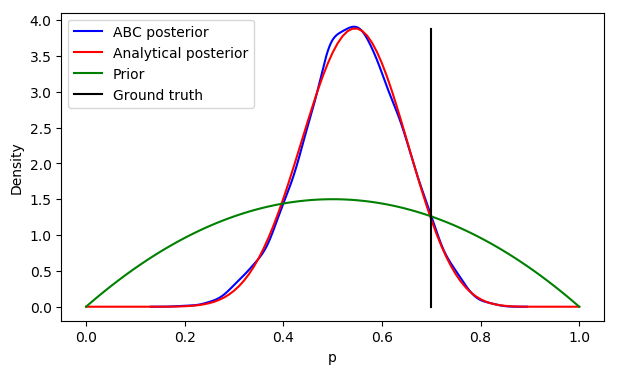

In [14]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### Extra slide: Approximate Bayesian Computation: Approximate posterior 

* The joint distribution of accapted parameter-data paris $(\theta^{\star}, s^{\star})$ is 
$$p(\theta^{\star}, s^{\star}) = p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon),$$
where $s^{\text{obs}} = S(y^{\text{obs}})$, $I$ indicator kernel, $\Delta$ distance function, and $\epsilon$ the threshold.



* Now assume that $S(s^{\star}) = S(s^{\text{obs}}) \,\, \text{iff} \,\, y^{\star} = y^{\text{obs}}$ and let $\epsilon = 0$. Now marginlizing $s^{\star}$ yields the true posterior:
$$ p(\theta^{\star}| s^{\text{obs}}) = \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star} = p(y |\theta^{\star}) p(\theta^{\star}) \propto  p(\theta^{\star}| y) .$$

* However, in (almost) all situations we sample from an approximate posterior: 

$$p^{\epsilon}_{\text{ABC}}(\theta^{\star} | s^{\text{obs}}) \propto \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star}.$$


#### Extra slide: Results for the AR2 model with observation noise

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/res_ar2_wasserstein.svg" width="800" height="2000" align="center"/>

#### Extra slide: Results for the MA2 model with observation noise

Model: $$y_i = x_i + e_i, \qquad e_i \sim N(0, \sigma_\epsilon),$$ $$x_i = z_i + \theta_1 z_{i-1} + \theta_2 z_{i-2}, \qquad z_i \sim N(0, 1).$$


<img src="fig/res_ma2_wasserstein.svg" width="800" height="2000" align="center"/>
